In [2]:
# Only run on initial setup or restart of EC2 instance
%pip install tensorflow
%pip install opencv-python==4.3.0.36
%pip install imutils

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers import LeakyReLU
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
epochs = 10                 # Number of Training Epochs
num_classes = 10            # Number of classes in the Fashion MNIST dataset
batch_size = 256
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

In [5]:
# Get the data from the keras repository
mnist_data = fashion_mnist.load_data()

# x = images, y = labels
x = mnist_data[0][0]
y = mnist_data[0][1]

# Split data test and train sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.
if K.image_data_format() == 'channels first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# Cast to a 32 bit float and then scale so the value is a float normalized between 0 and 1. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

# Function to decode one-hot encoding later on when evaluating performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

# Topological skeleton preprocessing function to be used with the Image Augmentation Data Generator.
def topological_skel(image):
    img = image
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel

# Set up the Image Augmentation Data Generator.
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 #preprocessing_function=topological_skel,
                                 fill_mode='nearest')
datagen.fit(x_train)

(19800, 10)


In [6]:
# Define sequential model and add layers
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# Print model summary
model.summary()
my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

In [7]:
# Flag to determine whether we use Keras Image augmentation data generator
augmentation = False

# Compile the model so we can fit it.
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Nadam(), 
              metrics=['accuracy'])

if not augmentation:
    # Fit the model and evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
    # Fit the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)

score = model.evaluate(x_test, y_test)

# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])

model.summary()

not using image augmentation
Epoch 1/10
158/158 [==============================] - 17s 97ms/step - loss: 0.8113 - accuracy: 0.7017 - val_loss: 0.5179 - val_accuracy: 0.7976
Epoch 2/10
158/158 [==============================] - 15s 96ms/step - loss: 0.4975 - accuracy: 0.8156 - val_loss: 0.4058 - val_accuracy: 0.8518
Epoch 3/10
158/158 [==============================] - 15s 95ms/step - loss: 0.4350 - accuracy: 0.8421 - val_loss: 0.3769 - val_accuracy: 0.8619
Epoch 4/10
158/158 [==============================] - 15s 96ms/step - loss: 0.4017 - accuracy: 0.8533 - val_loss: 0.3516 - val_accuracy: 0.8704
Epoch 5/10
158/158 [==============================] - 15s 96ms/step - loss: 0.3810 - accuracy: 0.8616 - val_loss: 0.3290 - val_accuracy: 0.8798
Epoch 6/10
158/158 [==============================] - 15s 95ms/step - loss: 0.3657 - accuracy: 0.8660 - val_loss: 0.3258 - val_accuracy: 0.8819
Epoch 7/10
158/158 [==============================] - 15s 96ms/step - loss: 0.3573 - accuracy: 0.8691 - val

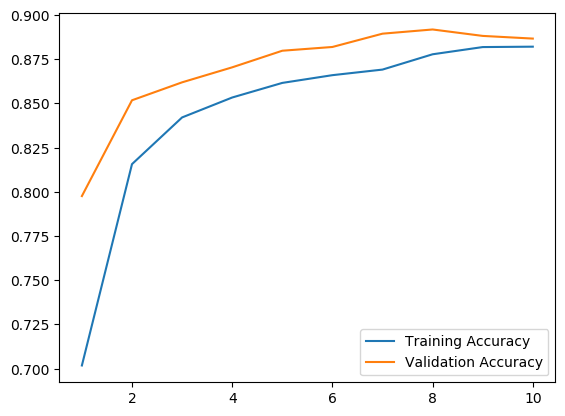

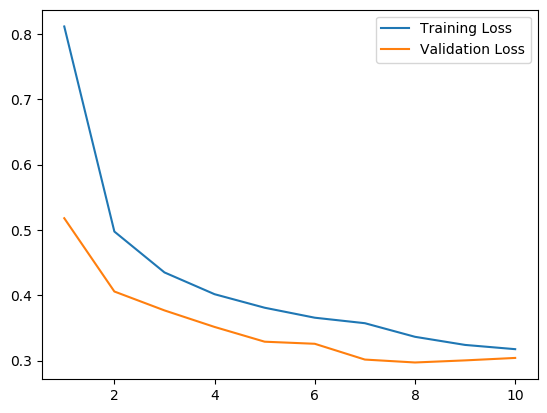

In [8]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))

# Plot training and test accuracy
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy", "Validation Accuracy"))
plt.show()

# Plot training and test loss
plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss", "Validation Loss"))
plt.show()

1/1 [==============================] - 0s 18ms/step


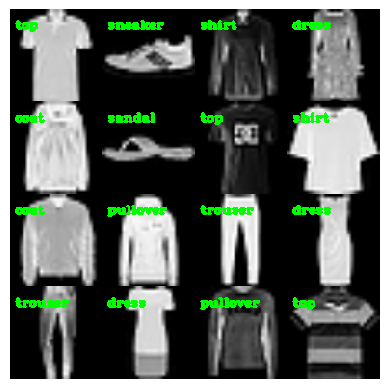

In [11]:
import cv2
from imutils import build_montages
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize list of output images
images = []

# Define labels in correct order
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# Randomly select testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# Classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# Extract the image from the testData if using "channels_first" ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# Else use "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")

    # Initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# Otherwise, the class label prediction is red (incorrect) 
	if prediction[0] != np.argmax(y_test[i]):
		color = (255, 0, 0)
 
	# Merge the channels into one image and resize the image from 28x28 to 96x96

	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    # Draw the predicted label on the image
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.60, color, 2)
 
	# Add the image to list of output images
	images.append(image)
# Construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]

# Show the output montage
plt.imshow(montage)
plt.axis('off')
plt.show()